In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import seaborn as sns
from scipy import ndimage

## Glimpse

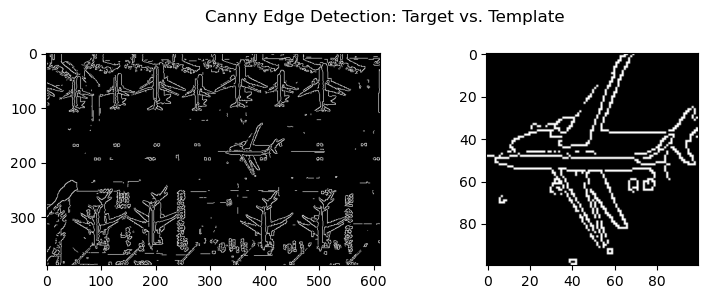

In [2]:
canny_min, canny_max = 150, 200

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

target_img = cv2.imread('./data/target_image.png', cv2.IMREAD_GRAYSCALE)
target_edge = cv2.Canny(target_img, canny_min, canny_max)
axes[0].imshow(target_edge, cmap='gray')

template_img = cv2.imread('./data/template_image.png', cv2.IMREAD_GRAYSCALE)
template_edge = cv2.Canny(template_img, canny_min, canny_max)
axes[1].imshow(template_edge, cmap='gray')

plt.suptitle("Canny Edge Detection: Target vs. Template")
plt.tight_layout()
plt.show()

## Implement

In [3]:
def xy2polar(i, j):
    """
    (y, x) -> (rho, theta)
    theta in radian
    """
    rho = np.sqrt(i*i + j*j)
    theta = np.arctan2(-i, -j) + np.pi
    return rho, theta

def polar2xy(rho, theta):
    """
    (rho, theta) -> (y, x)
    theta in radian
    """
    i = (rho * np.sin(theta)).astype(int)
    j = (rho * np.cos(theta)).astype(int)
    return i, j

def get_center_angle(edge, bin_num):
    """
    Get the angle of the edge in the center based on Hough Transform.
    
    - Input
    edge: edge data whose center is filled.
    bin_num: the number of angle(0~pi) cuts.
    
    - Output
    angle: bin number that edge is contained.
    """
    N, M = edge.shape
    assert edge[N//2, M//2] != 0, "Center is empty!"
    
    theta = np.linspace(0, np.pi, bin_num+1)[:bin_num]
    cos, sin = np.cos(theta), np.sin(theta)
    
    y, x = np.where(edge != 0)
    all_curve = x.reshape(-1, 1) * cos + y.reshape(-1, 1) * sin
    center_curve = (M//2) * cos + (N//2) * sin
    
    focus_score = np.exp(-0.5*(all_curve - center_curve)**2)
    focus_score = np.sum(focus_score, axis=0)
    angle = np.argmax(focus_score)
    return angle

In [4]:
class HitMap:
    """
    Handles the number and the location of hits.
    It is used by HoughTransform class.
    """
    def __init__(self, edge, Rtable, **kwargs):
        self.edge = edge
        self.N, self.M = edge.shape
        self.K = max(Rtable.shape[1], Rtable.shape[2])
        self.hitmap = np.zeros((self.N + 2*self.K, self.M + 2*self.K))
        self.Rtable = Rtable
        
        self.sampling_size =  kwargs['sampling_size']
        self.bin_num = kwargs['bin_num']
        self.threshold_rate = kwargs['threshold_rate']
        self.hitmap_filter_size = kwargs['hitmap_filter_size']
        
    def hit(self, i, j):
        """
        Get coordinate of the edge and update hitmap using Rtable.
        """
        h = self.sampling_size // 2
        angle = get_center_angle(self.edge[i-h:i+h, j-h:j+h], self.bin_num)
        
        K = self.K
        NN, MM = self.Rtable.shape[1]//2, self.Rtable.shape[2]//2
        self.hitmap[i-NN+K:i+NN+K, j-NN+K:j+NN+K] += self.Rtable[angle]
            
    def done(self):
        """
        No more update. Cut off the useless outer part.
        """
        K = self.K
        self.hitmap = self.hitmap[K:K+self.N, K:K+self.M]
            
    def show(self, default_img=None):
        """
        Print hitmap on the target image.
        """
        hmap = self.hitmap
        if self.hitmap_filter_size is not None:
            hmap = ndimage.maximum_filter(hmap, size=self.hitmap_filter_size)
            
        hmax, hmin = np.max(hmap), np.max(hmap) * self.threshold_rate
        # threshold & normalize
        hmap = np.where(hmap > hmin, hmap, hmin)
        hmap = hmap / hmax
        
        ax = plt.subplot()        
        if default_img is None:
            ax.imshow(self.edge, cmap='gray')
        else:
            ax.imshow(default_img, cmap='gray')
        sns.heatmap(hmap, alpha=0.75, xticklabels=False, yticklabels=False, ax=ax)
        
        plt.title("Hitmap on Original Image")
        plt.tight_layout()
        plt.show()


class HoughTransform:
    """
    Do the General Hough Transform.
    """
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.canny_min = kwargs['canny_min']
        self.canny_max = kwargs['canny_max']
        self.sampling_size =  kwargs['sampling_size']
        self.bin_num = kwargs['bin_num']
        self.scale_pool = kwargs['scale_pool']
        assert self.sampling_size % 2 == 1, "sampling_size should be odd!"
        
    def go(self, target, template):
        """
        Run the whole procedure.
        1. Get Rtable using template_edge.
        2. Vote with HitMap class.
        3. Show the hitmap with target image.
        """
        # Edge & Rtable
        target_edge = cv2.Canny(target, self.canny_min, self.canny_max)
        template_edge = cv2.Canny(template, self.canny_min, self.canny_max)
        Rtable = self.get_Rtable(template_edge)
        
        # Voting
        N, M = target_edge.shape
        hitmap = HitMap(target_edge, Rtable, **self.kwargs)
        h = self.sampling_size // 2
        for i in range(h, N-h):
            for j in range(h, M-h):
                if target_edge[i, j] == 0: continue
                hitmap.hit(i, j)
        hitmap.done()
        
        # Get the winner
        hitmap.show(target)
        
    def get_Rtable(self, edge):
        """
        Get Rtable in a form of convolution filter.
        Gaussian filter is used for the smoother Rtable.
        """
        N, M = edge.shape
        ri, rj = N//2, M//2
        h = self.sampling_size // 2

        Rtable = np.zeros((self.bin_num, 3*N, 3*M))
        for i in range(h, N-h):
            for j in range(h, M-h):
                if edge[i, j] == 0: continue
                angle = get_center_angle(edge[i-h:i+h, j-h:j+h], self.bin_num)
                di, dj = i - ri, j - rj
                rho, theta = xy2polar(di, dj)
                
                rot_angle = (angle + np.arange(self.bin_num)) % self.bin_num
                rot_theta = theta + np.arange(self.bin_num) / self.bin_num * np.pi
                for scale in self.scale_pool:
                    di, dj = polar2xy(scale * rho, rot_theta)
                    ni, nj = ri + di, rj + dj
                    Rtable[rot_angle, N + ni, M + nj] += 1
                    ni, nj = ri - di, rj - dj
                    Rtable[rot_angle, N + ni, M + nj] += 1
               
        Rtable = self.gaussian_filter(Rtable)
        Rtable = Rtable[:, N:2*N, M:2*M]
        return Rtable
    
    def gaussian_filter(self, field, sigma=1, fl=3):
        h = fl // 2        
        xx = np.arange(-h, h+1)
        x, y = np.meshgrid(xx, xx)
        gaussian = np.exp(-(x*x+y*y)/(2*sigma**2))
        gaussian /= np.sum(gaussian)
        
        ret = np.zeros_like(field)
        _, N, M = field.shape
        for i in range(N - fl):
            for j in range(M - fl):
                ret[:, i:i+fl, j:j+fl] += field[:, i:i+fl, j:j+fl] * gaussian
        return ret

In [5]:
def hough_transform(target, template, **kwargs):
    hough = HoughTransform(**kwargs)
    hough.go(target, template)

## Test 1: Original Image

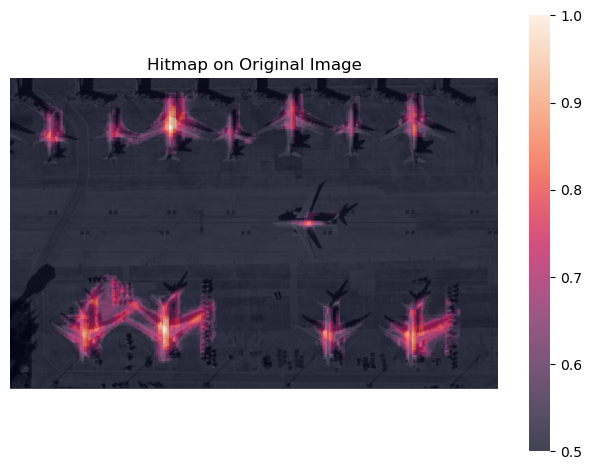

CPU times: user 4.23 s, sys: 384 ms, total: 4.62 s
Wall time: 4.6 s


In [6]:
%%time

kwargs = {
    'canny_min': 200,
    'canny_max': 400,
    'sampling_size': 15,
    'bin_num': 180,
    'threshold_rate': 0.5,
    'scale_pool': np.linspace(0.5, 2, 10),
    
    'hitmap_filter_size': 5,
}

hough_transform(target_img, template_img, **kwargs)

## Test 2: Scaled & Rotated Image

In [7]:
def rotate_image(img, rot, mag):
    h, w = img.shape
    cX, cY = w//2, h//2
    
    M = cv2.getRotationMatrix2D((cX, cY), rot, mag)
    processed_img = cv2.warpAffine(img, M, (w, h))
    return processed_img

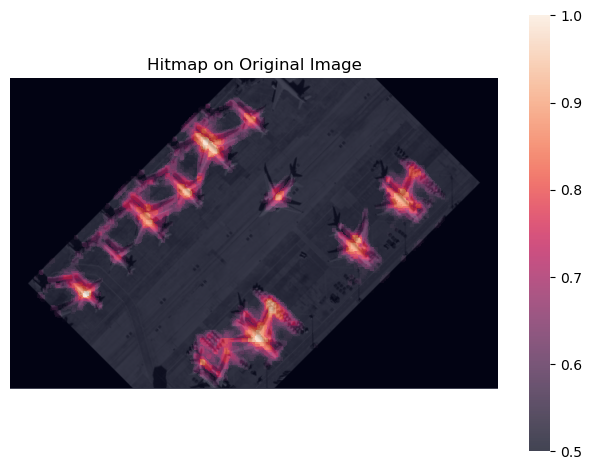

CPU times: user 4.14 s, sys: 71.8 ms, total: 4.21 s
Wall time: 4.19 s


In [8]:
%%time
hough_transform(rotate_image(target_img, 45, 0.8), template_img, **kwargs)